In [3]:
pr39 = "METQRASLCLGRWSLWLLLLGLVVPSASAQALSYREAVLRAVDRLNEQSSEANLYRLLELDQPPKADEDPGTPKPVSFTVKETVCPRPTRQPPELCDFKENGRVKQCVGTVTLNPSIHSLDISCNEIQSVRRRPRPPYLPRPRPPPFFPPRLPPRIPPGFPPRFPPRFPGKR"
from disassembly.simulate_proteolysis import simulate_proteolysis, enzyme_set, enzyme
import matplotlib.pyplot as plt

enzymes = enzyme_set(
    [
        enzyme({"K": 1}, "protease_iv"),
        enzyme({"K": 0.5, "R": 0.5}, "trypsin"),
        enzyme({"V": 0.5, "I": 0.25, "A": 0.15, "T": 0.1}, "elne"),
    ],
    [1, 0, 0],  # activities
    [1, 0, 0],  # abundances
)


P, sequence_graph = simulate_proteolysis(
    pr39,
    n_start=20,
    n_generate=200,
    endo_or_exo_probability=[0.5, 0.5],
    enzymes=enzymes,
)

 199 / 200
55 unique peptides. 220 total


 58 / 200 | 1.06, mean: 1.45 | Increasing | nz: 294
Learning rate decreased to 1.0
 110 / 200 | 1.74, mean: 0.87 | Increasing | nz: 324
Learning rate decreased to 0.5
 163 / 200 | 0.83, mean: 0.71 | Increasing | nz: 341
Learning rate decreased to 0.25
 199 / 200 | 0.82, mean: 0.74 | Plateau | nz: 346346

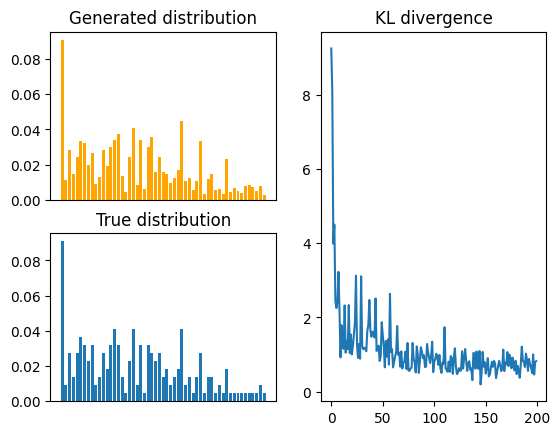

In [4]:
from disassembly.estimate_weights import estimate_weights

G, kls, generated, weights = estimate_weights(
    P=P,
    meta_enzyme=enzymes.meta_enzyme,
    exo_mult_factor=1,
    lr=2,
    n_iterations=200,
    N_T=200,
    alpha=0.05,
)

fig, axs = plt.subplot_mosaic(
    [["generated", "kl"], ["true", "kl"]], width_ratios=[2, 2]
)

generated_sum = {k: 0 for k in generated[0].keys()}

for p_generated in [
    generated[i]
    for i in range(
        len(generated.keys()) - int(len(generated.keys()) / 20), len(generated.keys())
    )
]:
    for k, v in p_generated.items():
        generated_sum[k] += v / 20

axs["true"].bar(P.keys(), [v / sum(P.values()) for v in P.values()])
axs["generated"].bar(
    generated_sum.keys(),
    [v / sum(generated_sum.values()) for v in generated_sum.values()],
    color="orange",
)
axs["kl"].plot(kls)
axs["true"].set_title("True distribution")
axs["generated"].set_title(f"Generated distribution")
axs["kl"].set_title("KL divergence")
axs["true"].set_xticks([])
axs["generated"].set_xticks([])
plt.show()

In [5]:
import numpy as np

real_vs_estimated_weights = []
for node in sequence_graph.nodes():
    sum_out_edges = sum(
        [data["weight"] for _, _, data in sequence_graph.out_edges(node, data=True)]
    )
    for source, target, data in sequence_graph.out_edges(node, data=True):
        real_weight = data["weight"] / sum_out_edges
        estimated_weight = G[source][target]["weight"]
        real_vs_estimated_weights.append((real_weight, estimated_weight))
    for source, target, data in G.out_edges(node, data=True):
        if ~sequence_graph.has_edge(source, target):
            estimated_weight = data["weight"]
            real_vs_estimated_weights.append((np.nan, estimated_weight))
print(sum([r for r, _ in real_vs_estimated_weights if str(r) != "nan"]))
print(sum([e for _, e in real_vs_estimated_weights]))

54.99999999999998
96.89207436430578


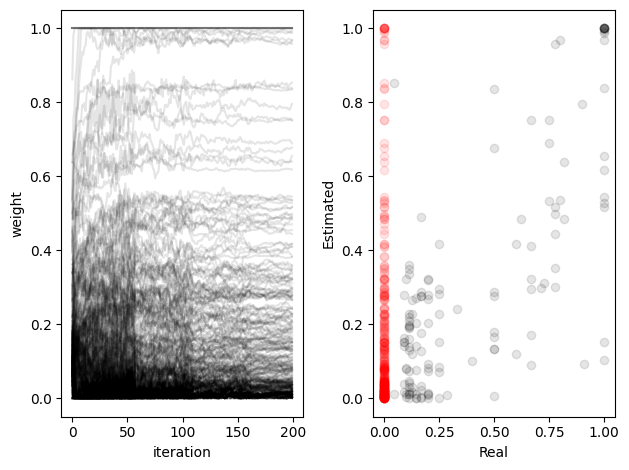

In [6]:
fig, axs = plt.subplots(1, 2)
axs[0].set_ylabel("weight")
axs[0].plot(weights.T, alpha=0.1, color="black")
for r, e in real_vs_estimated_weights:
    if str(r) == "nan":
        axs[1].scatter(0, e, color="red", alpha=0.1)
    else:
        axs[1].scatter(r, e, color="black", alpha=0.1)
axs[1].set_xlabel("Real")
axs[1].set_ylabel("Estimated")
axs[0].set_xlabel("iteration")
plt.tight_layout()
plt.show()

In [7]:
from disassembly.disassembly import get_disassembly_indexes
from disassembly.disassembly import get_disassembly

real_disassembly_indexes = get_disassembly_indexes(sequence_graph)
get_disassembly(P, real_disassembly_indexes)

Removing low prob. (<0.01) edges. Before: 79 | after: 79
 54 / 55 | checking 80 pathss
 Averaged DI: 7.07


9806.239237650245

In [8]:
estimated_disassembly_indexes = get_disassembly_indexes(G, min_weight=0.01)
get_disassembly(P, estimated_disassembly_indexes)

Removing low prob. (<0.01) edges. Before: 292 | after: 273
 54 / 55 | checking 4 pathsaths
 Averaged DI: 3.53


77.70791704560894

In [9]:
from disassembly.disassembly import get_disassembly_indexes_mc

mc_di = get_disassembly_indexes_mc(G, 10000)

['METQRASLCLGRWSLWLLLLGLVVPSASAQALSYREAVLRAVDRLNEQSSEANLYRLLELDQPPK', 'TVCPRPTRQPPELCDFK', 'DPGTPKPVSFTVK', 'ENGR', 'EDPGTPKPVSFTVKETVCPRPTRQ', 'ETVCPRPTRQPPEL', 'PGTPKPVSFTVKETVCPRPTRQPPE']


Text(0.5, 0.98, 'Disassembly indexes')

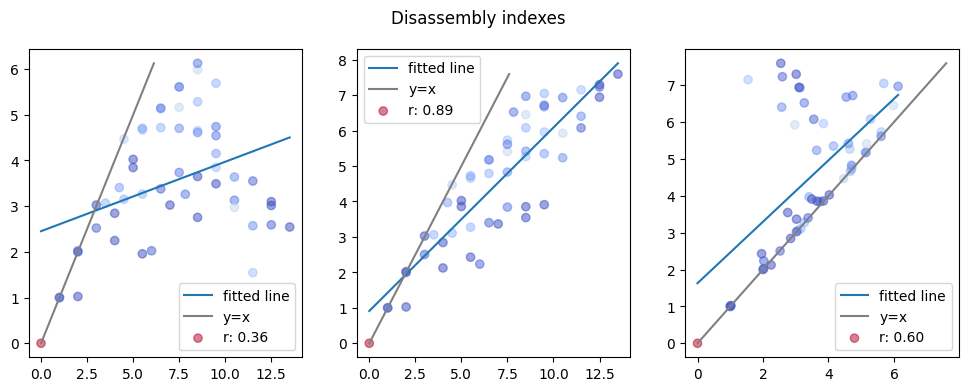

In [10]:
from scipy.stats import linregress
import numpy as np

fig, axs = plt.subplots(1,3, figsize=(12,4))
trues = []
ys_e = []
ys_mc = []
c = []
for key in P.keys():
    if str(np.mean(mc_di[key])) == "nan":
        print(key)
        continue
    trues.append((real_disassembly_indexes[key]))
    ys_e.append((estimated_disassembly_indexes[key]))
    ys_mc.append(np.mean(mc_di[key]))
    
    c.append(P[key])
a = 0
for xs, ys in [(trues, ys_e), (trues, ys_mc), (ys_e, ys_mc)]:
    regress = linregress(xs, ys)
    axs[a].plot(
        np.linspace(0, max(xs)),
        regress.intercept + np.linspace(0, max(xs)) * regress.slope,
        label="fitted line",
    )
    axs[a].plot(np.linspace(0, max(ys)), np.linspace(0, max(ys)), color="gray", label="y=x")
    axs[a].scatter(xs, ys, label=f"r: {regress.rvalue:.2f}", c=c, cmap="coolwarm", alpha=0.5)
    axs[a].legend()
    a+=1

plt.suptitle("Disassembly indexes")

In [11]:
import networkx as nx
import pandas as pd

aG = pd.DataFrame(
    nx.adjacency_matrix(G, nodelist=G.nodes()).toarray().T,
    index=G.nodes(),
    columns=G.nodes(),
).sort_index(key=lambda x: x.str.len())
aG = aG[aG.index]
pG = pd.DataFrame(
    nx.adjacency_matrix(sequence_graph, nodelist=G.nodes()).toarray().T,
    index=sequence_graph.nodes(),
    columns=sequence_graph.nodes(),
).sort_index(key=lambda x: x.str.len())
pG = pG[pG.index]

54.00000000000001 54.00000000000001 62.27844845044645


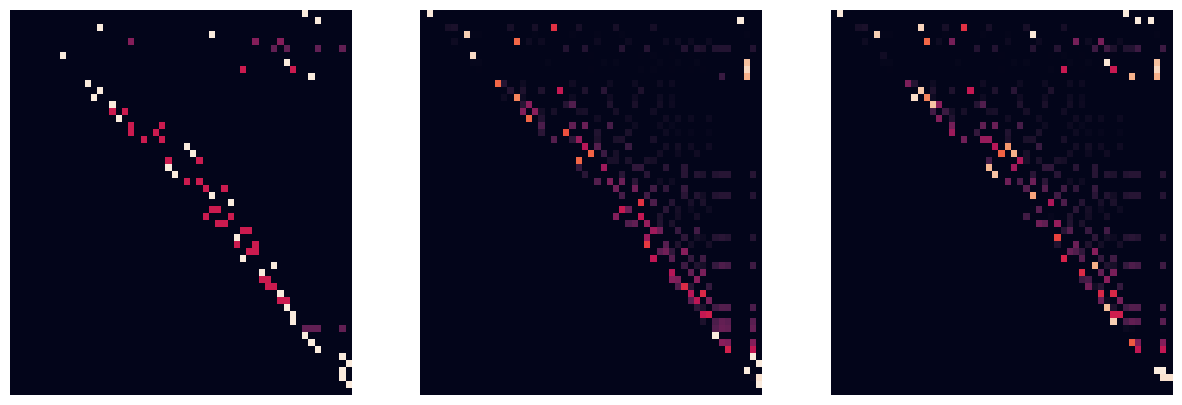

In [12]:
import seaborn as sns
fig, axs = plt.subplots(1,3, figsize=(15,5))

sns.heatmap(pG, ax=axs[0], cbar=None)
sns.heatmap(aG, ax=axs[1], cbar=None)
sns.heatmap(np.abs(pG-aG), ax=axs[2], cbar=None)

print(sum(sum(pG.values)), sum(sum(aG.values)), sum(sum(np.abs(pG-aG).values)))

for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])